<a href="https://colab.research.google.com/github/sanittawan/CAhomework/blob/master/8_Deep_Learning_and_text_training_models_Sanittawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week - 8 - Deep Neural Nets and Text - Training Models

### Sanittawan Tan's notebook

In this week we will be introduced to using Deep Neural Networks to work with text. We have already seen some uses of neural networks for text in our classification HW, where we used a simple neural network to classify text - it performs quite well, but they can come up short in more sophisticated classification tasks, such as in predicting intent. We have also seen neural nets in the form of word embeddings such as Word2Vec - and while they certainly work well, they have some drawbacks, such as dealing with words with multiple meanings. 

BERT, which is a language model built using bidirectional encoders, allows us to have a powerful pre-trained model which we can then use to perform our own tasks based on the data we are analysing. 

In this notebook we will use ```huggingface/transformers```, which is a python package which allows for an easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, though to reach state-of-the-art results we will stick with using BERT and similar models.

To demonstrate this, we will use the [Corpus of Linguistic Acceptability](https://nyu-mll.github.io/CoLA/). We will also be using BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences.
There are a bunch of new packages and methods we will be using so be sure to update lucem_illud_2020.

Note that this notebook is different to take advantage of the GPU here. We only run the GPU heavy tasks here, where we need models to be fine-tuned.

The first section contains the CoLA classification task, the second contains training a model on Trump tweets, and the last bit has us training a model on US and UK blog posts.

To switch on your GPU, go to edit -> notebook settings -> hardware accelerator -> enable GPU.


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

     |████████████████████████████████| 501kB 2.7MB/s 
     |████████████████████████████████| 3.7MB 52.6MB/s 
     |████████████████████████████████| 1.0MB 39.0MB/s 
     |████████████████████████████████| 870kB 35.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=4e1103f94decff31bae17ae72825586dde164873595b9ff36eaab41661f52277
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

We'll now load the CoLA dataset up here to Google Colab.

In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=90f643eb7815e4ea9d3453f9248566ae33818931de94f83ee468d582bc4ae116
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [0]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
3128,l-93,0,*,Paul yawned at Mary.
4609,ks08,1,NaN,John has taken Bill to the library.
5135,ks08,0,*,John that we are looking for showed up.
1532,r-67,1,NaN,Mary scratched her arm too.
6541,g_81,0,*,Who did you wonder saw Kim?
1734,r-67,1,NaN,"They said that Tom would pay up, and pay up he..."
8391,ad03,0,*,I thought she is pregnant
2011,rhl07,1,NaN,Fred kicked the ball over the fence.
1788,r-67,1,NaN,This rock is too heavy for me to begin to deci...
179,cj99,0,*,"I don't plan to lock the door, no matter how f..."


In [0]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
4753,To which man did you talk to?,0
1214,Rutherford is understood. by himself.,0
533,Fruit hit the roof against the ground.,0
2724,We contributed her our paycheck.,0
4474,I do not be happy.,0


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Introducing Deep Neural Nets

A popular, simplified package for introducing deep neural networks is [Keras](https://keras.io). It is a high level package in that we don't bother with every detail or hyper-parameter associated with the neural network (e.g., regularizers), and can stack on layers directly. For a rapid tutorial on neural networks for text such as the LSTM or the Recurrent Neural Network, Colah's blog is a great start. [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is an article on LSTMs, and if you'd like to  learn about RNN, Andrej Karpathy does a great job in [this blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), in addition to our reading from the newest online verion of Jurafsky & Martin's review of deep learning methods in their book on speech and language processing, chapters [6,7,9,10](https://web.stanford.edu/~jurafsky/slp3/), and the [*Deep Learning*](https://www.deeplearningbook.org/) book by Goodfellow, Bengio & Courville.

In the following cells we build a basic deep net that has an embedding layer and an LSTM to perform classification. This is to illustrate the process of using Keras, which is a very popular library for such work. It may not yield state of the art performance because it constrains the hyperparameters you can tune, but is nonetheless an useful tool and works well on some datasets.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [0]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [0]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6081 - acc: 0.7038
Epoch 2/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6084 - acc: 0.7038
Epoch 3/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6086 - acc: 0.7038
Epoch 4/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6084 - acc: 0.7038
Epoch 5/10
7695/7695 [==============================] - 46s 6ms/step - loss: 0.6083 - acc: 0.7038
Epoch 6/10
7695/7695 [==============================] - 46s 6ms/step - loss: 0.6080 - acc: 0.7038
Epoch 7/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6083 - acc: 0.7038
Epoch 8/10
7695/7695 [==============================] - 46s 6ms/step - loss: 0.6084 - acc: 0.7038
Epoch 9/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6081 - acc: 0.7038
Epoch 10/10
7695/7695 [==============================] - 46s 6ms/step - loss: 0.6081 - acc: 0.7038


In [0]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm2.add(LSTM(32))
model_lstm2.add(LSTM(32))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(train_inputs, train_labels, epochs=10, batch_size=batch_size)

Epoch 1/10
7695/7695 [==============================] - 49s 6ms/step - loss: 0.6143 - acc: 0.7025
Epoch 2/10
7695/7695 [==============================] - 48s 6ms/step - loss: 0.6084 - acc: 0.7038
Epoch 3/10
7695/7695 [==============================] - 48s 6ms/step - loss: 0.6087 - acc: 0.7038
Epoch 4/10
7695/7695 [==============================] - 48s 6ms/step - loss: 0.6089 - acc: 0.7038
Epoch 5/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6083 - acc: 0.7038
Epoch 6/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6086 - acc: 0.7038
Epoch 7/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6085 - acc: 0.7038
Epoch 8/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6084 - acc: 0.7038
Epoch 9/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6083 - acc: 0.7038
Epoch 10/10
7695/7695 [==============================] - 47s 6ms/step - loss: 0.6081 - acc: 0.7038


### On with BERT!

So while Neural Networks can do a good job with some kind of classification tasks, they don't perform too well on intent classification. Let us see how BERT might do. 

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Loading our Models

### Train Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.
We'll load BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.
Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.
OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:30.
  Batch    80  of    241.    Elapsed: 0:01:00.
  Batch   120  of    241.    Elapsed: 0:01:30.
  Batch   160  of    241.    Elapsed: 0:02:01.
  Batch   200  of    241.    Elapsed: 0:02:32.
  Batch   240  of    241.    Elapsed: 0:03:02.

  Average training loss: 0.50
  Training epcoh took: 0:03:03

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:31.
  Batch    80  of    241.    Elapsed: 0:01:01.
  Batch   120  of    241.    Elapsed: 0:01:32.
  Batch   160  of    241.    Elapsed: 0:02:02.
  Batch   200  of    241.    Elapsed: 0:02:33.
  Batch   240  of    241.    Elapsed: 0:03:04.

  Average training loss: 0.31
  Training epcoh took: 0:03:04

Running Validation...
  Accuracy: 0.86
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:31.
  

In [0]:
loss_values

[0.49987454996811403,
 0.3096145743280031,
 0.199634012762318,
 0.14039200691977724]

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [0]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
matthews_set

[-0.14856415213808927,
 -0.050964719143762556,
 0.4732058754737091,
 0.5096447293679518,
 0.5945883900105632,
 0.7410010097502685,
 0.5555555555555556,
 0.47519096331149147,
 0.9165151389911681,
 0.7704873741021288,
 0.9229582069908973,
 0.647150228929434,
 0.8150678894028793,
 0.647150228929434,
 0.3268228676411533,
 0.5716350506349809,
 0.0]

In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.514


We now want to save this model to disk. Once you save it to disk, right click on the file and save it to your local computer to use it on your notebook. You would have maybe trained your model on your own dataset, in which case you would also need to upload your data, or load it using wget as we did before.

NOTE: the files are accessible, both uploading and downloading, on the left hand side of the page, under the "folder" section.

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

#### Load and Prepare Data

Since the data for my final project does not involve classification as much, I am using a given data on Obama and Clinton press releases used in week 3 homework. I am going to classify these press releases if they belong to Obama or Clinton. 

In [0]:
from google.colab import files
uploaded = files.upload()

Saving ObamaClintonReleases.csv to ObamaClintonReleases.csv


In [0]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['ObamaClintonReleases.csv']))

In [0]:
df['label'] = [s == 'Obama' for s in df['targetSenator']]

In [0]:
df.rename(columns={"text": "sentence"}, inplace=True)

In [0]:
print(df.shape)
print(df.shape[0]*0.15)

(1709, 8)
256.34999999999997


In [0]:
df.columns

Index(['Unnamed: 0', 'download_url', 'html_url', 'name', 'path', 'sentence',
       'targetSenator', 'label'],
      dtype='object')

In [0]:
# Make a test set
train_set = df.sample(frac=0.85, random_state=2020)
test_set = df.drop(train_set.index)

In [0]:
test_set.reset_index(drop=True, inplace=True)

In [0]:
# check size
print(train_set.shape)
print(test_set.shape)

(1453, 8)
(256, 8)


In [0]:
print(train_set.columns)
print(test_set.columns)

Index(['Unnamed: 0', 'download_url', 'html_url', 'name', 'path', 'sentence',
       'targetSenator', 'label'],
      dtype='object')
Index(['Unnamed: 0', 'download_url', 'html_url', 'name', 'path', 'sentence',
       'targetSenator', 'label'],
      dtype='object')


In [0]:
# use train set to split into train and validation set as in the example
# begin with preprocessing

train_df = train_set.copy()

# Create sentence and label lists
sentences = train_df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_df.label.values

In [0]:
p_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

p_tokenized_texts = [p_tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence:")
print(p_tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'may', '12', '2005', 'senator', 'clinton', 'co', 'sponsors', 'legislation', 'to', 'ensure', 'homeland', 'security', 'funding', 'allocated', 'based', 'on', 'threat', 'level', 'legislation', 'a', 'good', 'first', 'step', 'toward', 'targeting', 'federal', 'dollars', 'to', 'highest', 'risk', 'communities', 'washington', 'dc', 'building', 'on', 'her', 'long', 'standing', 'commitment', 'to', 'ensuring', 'that', 'homeland', 'security', 'funding', 'is', 'allocated', 'based', 'on', 'threat', 'level', 'and', 'risk', 'senator', 'hillary', 'rod', '##ham', 'clinton', 'announced', 'that', 'she', 'is', 'co', 'sponsoring', 'legislation', 'introduced', 'today', 'to', 'require', 'that', 'the', 'federal', 'government', 'use', 'a', 'threat', 'based', 'formula', 'as', 'recommended', 'by', 'the', '9', '11', 'commission', 'the', 'bi', '##partisan', 'legislation', 'the', 'homeland', 'security', 'forward', 'funding', 'act', 'of', '2005', 'will', 'require', 'that', 'federa

In [0]:
# find the longest sequence
max_length = 0
for t in p_tokenized_texts:
  length = len(t)
  if length > max_length:
    max_length = length
print(max_length)

# the press releases can be very long. I will use max length of 512. 

6230


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 512

In [0]:
input_ids = [p_tokenizer.convert_tokens_to_ids(x) for x in p_tokenized_texts]

In [0]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
X_train, X_valid, y_train, y_valid = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
X_train_masks, X_validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

#### Keras

In [0]:
vocab_in_size = p_tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(y_train))
batch_size = 32
print(no_labels)
print(vocab_in_size)

2
30522


In [0]:
model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm1.add(LSTM(unit))
model_lstm1.add(Dense(no_labels, activation='softmax'))
model_lstm1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 512, 32)           976704    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_lstm1 = model_lstm1.fit(X_train, y_train, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
1307/1307 [==============================] - 32s 24ms/step - loss: 0.6799 - acc: 0.5891
Epoch 2/10
1307/1307 [==============================] - 30s 23ms/step - loss: 0.6589 - acc: 0.5945
Epoch 3/10
1307/1307 [==============================] - 31s 23ms/step - loss: 0.6689 - acc: 0.6144
Epoch 4/10
1307/1307 [==============================] - 30s 23ms/step - loss: 0.6317 - acc: 0.7674
Epoch 5/10
1307/1307 [==============================] - 30s 23ms/step - loss: 0.5688 - acc: 0.7789
Epoch 6/10
1307/1307 [==============================] - 29s 22ms/step - loss: 0.2341 - acc: 0.9151
Epoch 7/10
1307/1307 [==============================] - 31s 24ms/step - loss: 0.0341 - acc: 0.9931
Epoch 8/10
1307/1307 [==============================] - 30s 23ms/step - loss: 0.0319 - acc: 0.9931
Epoch 9/10
1307/1307 [==============================] - 30s 23ms/step - loss: 0.0245 - acc: 0.9939
Epoch 10/10
1307/1307 [==============================] - 29s 23ms/step - loss: 0.3016 - acc: 0.9044


The accuracy rate of my LSTM on the training set is really good! It started from ~60% to more than ~90%. Let's switch to BERT and see how it does.

#### BERT

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(X_train)
validation_inputs = torch.tensor(X_valid)
train_labels = torch.tensor(y_train.astype(int))
validation_labels = torch.tensor(y_valid.astype(int))
train_masks = torch.tensor(X_train_masks)
validation_masks = torch.tensor(X_validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# use ready-made function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Useful function to print time 
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

I am going to modify the given code to train a BERT model.

In [0]:
# a hack to increase RAM on Colab
# https://towardsdatascience.com/upgrade-your-memory-on-google-colab-for-free-1b8b18e8791d
# a = []
# while(1):
#     a.append('1')

In [0]:
torch.tensor(y_train.astype(int))

tensor([1, 1, 0,  ..., 0, 0, 0])

In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     82.    Elapsed: 0:00:34.
  Batch    80  of     82.    Elapsed: 0:01:08.

  Average training loss: 0.22
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     82.    Elapsed: 0:00:34.
  Batch    80  of     82.    Elapsed: 0:01:07.

  Average training loss: 0.01
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     82.    Elapsed: 0:00:34.
  Batch    80  of     82.    Elapsed: 0:01:07.

  Average training loss: 0.00
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     82.    Elapsed: 0:00:34.
  Batch    80  of     82.    Elapsed: 0:01:07.

  Average training loss: 0.00
  Training epcoh took: 0:01:09

Ru

The BERT model does so well that the validation accuracy is 1 in each iteration which is very impressive.

In [0]:
# validate with the test set
# Create sentence and label lists
df = test_set
sentences = df.sentence.values
labels = df.label.values
MAX_LEN = 512

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
p_tokenized_texts = [p_tokenizer.tokenize(sent) for sent in sentences]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []

# # For every sentence...
# for sent in sentences:
#     # `encode` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     encoded_sent = p_tokenizer.encode(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                    )
    
#     input_ids.append(encoded_sent)

# Pad our input tokens

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 256 test sentences...
    DONE.


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

print(matthews_set)

Calculating Matthews Corr. Coef. for each batch...
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.992


As we can notice, the matthews correlation coefficient is very high, i.e., ~99% on this particular data set. This means that BERT actually does very well even on the test set.

In [0]:
# save model to file
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
p_tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
print( os.getcwd() )
print( os.listdir() )

from google.colab import files
files.download( "./model_save/vocab.txt" )

/content
['.config', 'ObamaClintonReleases.csv', 'model_save', 'sample_data']


In [0]:
files.download( "./model_save/special_tokens_map.json" )

In [0]:
print( os.listdir('model_save') )

['pytorch_model.bin', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'config.json']


In [0]:
files.download( "./model_save/pytorch_model.bin" )

In [0]:
files.download( "./model_save/tokenizer_config.json" )

In [0]:
files.download( "./model_save/config.json" )

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

#### Similarities

In [0]:
from transformers import BertModel

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Since the texts pertaining to my final project would not give a good example for this task, I decided to use a verse from Kustis Blow's the Breaks (a song)!

In [0]:
raw_text = "Breaks on a bus brakes on a car \
Breaks to make you a superstar \
Breaks to win and breaks to lose \
But these here breaks will rock your shoes \
And these are the breaks \
Break it up, break it up, break it up"

text = []
tmp = raw_text.split()
for t in tmp:
  if t != "":
    text.append(t.lower())
text = " ".join(text)
print(text)

breaks on a bus brakes on a car breaks to make you a superstar breaks to win and breaks to lose but these here breaks will rock your shoes and these are the breaks break it up, break it up, break it up


In [0]:
# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
breaks        7,807
on            2,006
a             1,037
bus           3,902
brakes       13,627
on            2,006
a             1,037
car           2,482
breaks        7,807
to            2,000
make          2,191
you           2,017
a             1,037
superstar    18,795
breaks        7,807
to            2,000
win           2,663
and           1,998
breaks        7,807
to            2,000
lose          4,558
but           2,021
these         2,122
here          2,182
breaks        7,807
will          2,097
rock          2,600
your          2,115
shoes         6,007
and           1,998
these         2,122
are           2,024
the           1,996
breaks        7,807
break         3,338
it            2,009
up            2,039
,             1,010
break         3,338
it            2,009
up            2,039
,             1,010
break         3,338
it            2,009
up            2,039
[SEP]           102


In [0]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [0]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
output = model_embedding(tokens_tensor)
print(len(output[0][0][0]), len(output[1][0]))

768 768


In [0]:
word_embeddings, sentence_embedding = output
word_embeddings[0]

tensor([[-0.0800,  0.2664,  0.1553,  ..., -0.5823,  0.0486,  0.2360],
        [ 0.7006,  0.5506, -0.1479,  ..., -0.1412,  0.3838, -0.1449],
        [-0.5792,  0.3457, -0.3020,  ..., -0.0965, -0.0448,  0.0825],
        ...,
        [ 0.0129, -0.7089,  0.9638,  ...,  0.1003, -0.0223,  0.4040],
        [ 0.3847, -0.2060,  0.2848,  ...,  0.6658,  0.2594, -0.3116],
        [ 0.7675,  0.5152, -0.0658,  ..., -0.4304, -0.5382, -0.2533]],
       grad_fn=<SelectBackward>)

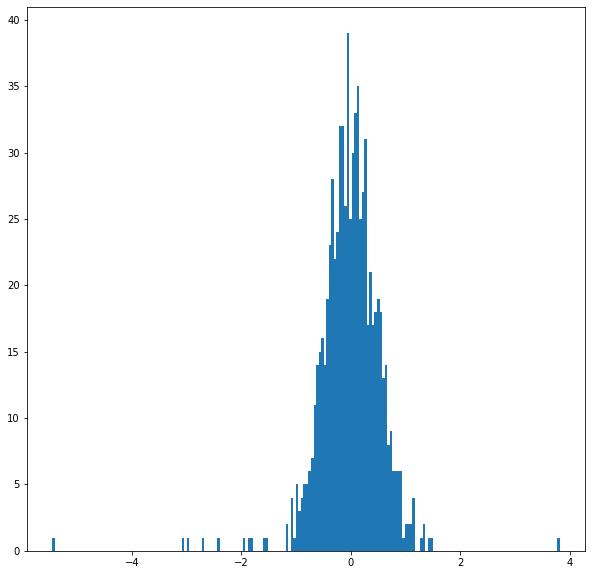

In [0]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [0]:
# word vectors 
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [0]:
# sectence vecs
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 breaks
2 on
3 a
4 bus
5 brakes
6 on
7 a
8 car
9 breaks
10 to
11 make
12 you
13 a
14 superstar
15 breaks
16 to
17 win
18 and
19 breaks
20 to
21 lose
22 but
23 these
24 here
25 breaks
26 will
27 rock
28 your
29 shoes
30 and
31 these
32 are
33 the
34 breaks
35 break
36 it
37 up
38 ,
39 break
40 it
41 up
42 ,
43 break
44 it
45 up
46 [SEP]


In [0]:
from scipy.spatial.distance import cosine


In [0]:
# Calculate the cosine similarity between the word breaks
# in "these are the breaks" vs "breaks to win" (different meanings).
diff_bank = 1 - cosine(token_vecs[34], token_vecs[15])

# Calculate the cosine similarity between the word bank
# in "break it up" vs "break it up" (same meaning).
same_bank = 1 - cosine(token_vecs[35], token_vecs[39])

print('Vector similarity for *different* meanings:  {:.2f}'.format(diff_bank))
print('Vector similarity for  *similar*  meanings:  {:.2f}'.format(same_bank))

Vector similarity for *different* meanings:  0.74
Vector similarity for  *similar*  meanings:  0.88


Indeed, the words that are supposed to be similar turn out to be more similar than "breaks" with different meanings.

In [0]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [0]:
word_6 = word_vector(text, 6, model_embedding, tokenizer)

In [0]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [0]:
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

#### Try pipeline

In [0]:
from transformers import pipeline

In [0]:
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

Take Donald Trump's 2016 inaugural address as an example for sentiment analysis. 

In [0]:
speech = '           Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow Americans and people of the world, thank you.      We, the citizens of America, are now joined in a great national effort to rebuild our country and restore its promise for all of our people. Together we will determine the course of America and the world for many, many years to come.      We will face challenges. We will confront hardships. But we will get the job done. Every four years, we gather on these steps to carry out the orderly and peaceful transfer of power.      And we are grateful to President Obama and First Lady Michelle Obama for their gracious aid throughout this transition. They have been magnificent. Thank you.      Today<U+0092>s ceremony, however, has very special meaning. Because today, we are not merely transferring power from one administration to another or from one party to another, but we are transferring power from Washington, D.C., and giving it back to you, the people.      For too long, a small group in our nation<U+0092>s capital has reaped the rewards of government while the people have borne the cost. Washington flourished, but the people did not share in its wealth. Politicians prospered, but the jobs left and the factories closed.      The establishment protected itself but not the citizens of our country. Their victories have not been your victories. Their triumphs have not been your triumphs. And while they celebrated in our nation<U+0092>s capital, there was little to celebrate for struggling families all across our land. That all changes starting right here and right now, because this moment is your moment: it belongs to you. It belongs to everyone gathered here today and everyone watching all across America. This is your day, this is your celebration, and this, the United States of America, is your country.      What truly matters is not which party controls our government but whether our government is controlled by the people. January Twentieth, Two Thousand and Seventeen will be remembered as the day the people became the rulers of this nation again. The forgotten men and women of our country will be forgotten no longer.      Everyone is listening to you now. You came by the tens of millions to become part of a historic movement, the likes of which the world has never seen before. At the center of this movement is a crucial conviction<U+0097>that a nation exists to serve its citizens.      Americans want great schools for their children, safe neighborhoods for their families and good jobs for themselves. These are just and reasonable demands of righteous people and a righteous public. But for too many of our citizens, a different reality exists: mothers and children trapped in poverty in our inner cities, rusted out factories scattered like tombstones across the landscape of our nation, an education system flushed with cash but which leaves our young and beautiful students deprived of all knowledge<U+0097>and the crime, and the gangs, and the drugs that have stolen too many lives and robbed our country of so much unrealized potential. This American carnage stops right here and stops right now.       We are one nation, and their pain is our pain, their dreams are our dreams, and their success will be our success. We share one heart, one home and one glorious destiny.       The oath of office I take today is an oath of allegiance to all Americans. For many decades, we<U+0092>ve enriched foreign industry at the expense of American industry, subsidized the armies of other countries while allowing for the very sad depletion of our military. We defended other nation<U+0092>s borders while refusing to defend our own<U+0097>and spent trillions and trillions of dollars overseas while America<U+0092>s infrastructure has fallen into disrepair and decay. We<U+0092>ve made other countries rich while the wealth, strength and confidence of our country has dissipated over the horizon. One by one, the factories shuttered and left our shores with not even a thought about the millions and millions of American workers that were left behind. The wealth of our middle class has been ripped from their homes and then redistributed all across the world. But, that is the past and now we are looking only to the future.       We, assembled here today, are issuing a new decree to be heard in every city, in every foreign capital and in every hall of power. From this day forward, a new vision will govern our land. From this day forward, it<U+0092>s going to be only America first. America first!       Every decision<U+0097>on trade, on taxes, on immigration, on foreign affairs<U+0097>will be made to benefit American workers and American families. We must protect our borders from the ravages of other countries making our products, stealing our companies and destroying our jobs. Protection will lead to great prosperity and strength.       I will fight for you with every breath in my body; and I will never, ever let you down. America will start winning again<U+0097>winning like never before.       We will bring back our jobs. We will bring back our borders. We will bring back our wealth, and we will bring back our dreams. We will build new roads and highways and bridges and airports and tunnels and railways all across our wonderful nation. We will get our people off of welfare and back to work, rebuilding our country with American hands and American labor. We will follow two simple rules: buy American and hire American.       We will seek friendship and goodwill with the nations of the world; but, we do so with the understanding that it is the right of all nations to put their own interests first. We do not seek to impose our way of life on anyone but rather to let it shine as an example. We will shine for everyone to follow.       We will reinforce old alliances and form new ones, and unite the civilized world against radical Islamic terrorism, which we will eradicate completely from the face of the earth.       At the bedrock of our politics will be a total allegiance to the United States of America; and through our loyalty to our country, we will rediscover our loyalty to each other. When you open your heart to patriotism, there is no room for prejudice.       The Bible tells us how good and pleasant it is when God<U+0092>s people live together in unity. We must speak our minds openly, debate our disagreements honestly, but always pursue solidarity. When America is united, America is totally unstoppable.       There should be no fear: we are protected, and we will always be protected. We will be protected by the great men and women of our military and law enforcement; and most importantly, we will be protected by God.       Finally, we must think big and dream even bigger. In America, we understand that a nation is only living as long as it is striving. We will no longer accept politicians who are all talk and no action, constantly complaining but never doing anything about it. The time for empty talk is over. Now arrives the hour of action.       Do not allow anyone to tell you that it cannot be done. No challenge can match the heart and fight and spirit of America. We will not fail. Our country will thrive and prosper again.       We stand at the birth of a new millennium: ready to unlock the mysteries of space; to free the earth from the miseries of disease; and to harness the energies, industries and technologies of tomorrow. A new national pride will stir ourselves, lift our sights and heal our divisions. It<U+0092>s time to remember that old wisdom our soldiers will never forget<U+0097>that whether we are black or brown or white, we all bleed the same red blood of patriots. We all enjoy the same glorious freedoms, and we all salute the same great American flag. And whether a child is born in the urban sprawl of Detroit or the wind-swept plains of Nebraska, they look up at the same night sky, they fill their heart with the same dreams and they are infused with the breath of life by the same Almighty Creator.       So to all Americans in every city near and far, small and large, from mountain to mountain, from ocean to ocean, hear these words: you will never be ignored again. Your voice, your hopes and your dreams will define our American destiny. And your courage and goodness and love will forever guide us along the way.       Together, we will make America strong again. We will make America wealthy again. We will make America proud again. We will make America safe again. And yes, together, we will make America great again!       Thank you. God bless you. And God bless America.       Thank you. God bless America.                '
tmt = speech.split()
new_speech = []
for s in tmt:
  if s != '':
    new_speech.append(s.lower())
new_speech = ' '.join(new_speech)

In [0]:
nlp_sentiment(new_speech)

[{'label': 'POSITIVE', 'score': 0.998232}]

The result is that the speech is very positive which is expected.

#### End of exercise 2
I test the given code here before making my own chatbot below.

In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [0]:
# see what BERT will give us from Gen 1:1
sequence = "In the beginning God created the heavens and the earth"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

In the beginning God created the heavens and the earth—where there was a center, and to no one there was a central body; he that has seen God create the earth is also His central body; from thence the seven heavens were created, and


Ah... pretty interesting

### Results

We get the same result as our Jupyter Notebook, but our model was trained in just 10 mins, as opposed to 12 hours without GPU. Super neat! We now skip the parts which just use the pre-trained model, as you can follow those in the Jupyter Notebook. The purpose of this notebook is to get you to upload your data, train your models, download them, and use them in your Jupyter Notebooks.

### Fine-tuning BERT and GPT

We now do our other model fine-tuning.
You have to upload your files to the colab file - on the left of the screen, on the files section, click the upload section, and upload test_text_trump, train_text_trump, run_generation.py, and run_language_modelling.py. These files would be on the GitHub repository.

We start with training a model on Trump tweets, and then save the model to disk and load it in the Jupyter notebook. The following two lines of code does the language training and then text generation. The important part here is training your model, and then downloading that by right clicking the file name in the files section on the top left of the screen. In my xase, all the files were saved in /content/output_gpt_trump

In [0]:
# upload manually
test_text_trump = files.upload()

Saving test_text_trump to test_text_trump


In [0]:
# upload manually
train_text_trump = files.upload()

Saving train_text_trump to train_text_trump


In [0]:
# upload manually
run_generation = files.upload()

Saving run_generation.py to run_generation.py


In [0]:
# upload manually
run_language_modelling = files.upload()

Saving run_language_modelling.py to run_language_modelling.py


In [0]:
# check if files are properly uploaded
print( os.listdir() )

['.config', 'ObamaClintonReleases.csv', 'run_generation.py', 'run_language_modelling.py', 'test_text_trump', 'train_text_trump', 'model_save', 'sample_data']


In [0]:
torch.cuda.empty_cache() 

In [0]:
!python /content/run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=/content/train_text_trump --do_eval --eval_data_file=/content/test_text_trump --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/05/2020 05:50:55 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/05/2020 05:50:55 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/05/2020 05:50:55 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20

In [0]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/output_gpt_trump

03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   Model name '/content/output_gpt_trump' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming '/content/output_gpt_trump' is a path, a model identifier, or url to a directory containing tokenizer files.
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   Didn't find file /content/output_gpt_trump/added_tokens.json. We won't load it.
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/vocab.json
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/merges.txt
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   loading file None
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_trump/special_tokens_map.json
03/05/2020 06:25:15 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_tr

In [0]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [0]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to have to show the world a little more backbone about the Iraq War. It will be tough, but with me there is. @foxandfriends," she said on @foxandfriends, via @nbcavs."I


In [0]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be in charge. He's going to put his own people into place. "I am the boss, so when people get scared when they get scared about something they need to learn from, I'll hold them accountable for that to


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

I am going to train a bot to write Obama's press releases using the press releases data set that I used before. Before training here, I generated train and test set using my local machine. The code is below, but it won't run on colab.

In [0]:
ObamaClintonReleases = pd.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

In [0]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

In [0]:
filter1 = ObamaClintonReleases['category'] == 1
df = ObamaClintonReleases[filter1]

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

train_text.to_frame().to_csv(r'train_text_obama', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_obama', header=None, index=None, sep=' ', mode='a')

In [0]:
torch.cuda.empty_cache() 

In [11]:
!python /content/run_language_modelling.py --output_dir=output_gpt_obama --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=/content/train_text_obama --do_eval --eval_data_file=/content/test_text_obama --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

Traceback (most recent call last):
  File "/content/run_language_modelling.py", line 799, in <module>
    main()
  File "/content/run_language_modelling.py", line 650, in main
    args.output_dir
ValueError: Output directory (output_gpt_obama) already exists and is not empty. Use --overwrite_output_dir to overcome.


In [0]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/output_gpt_obama

03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   Model name '/content/output_gpt_obama' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming '/content/output_gpt_obama' is a path, a model identifier, or url to a directory containing tokenizer files.
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   Didn't find file /content/output_gpt_obama/added_tokens.json. We won't load it.
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_obama/vocab.json
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_obama/merges.txt
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   loading file None
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_obama/special_tokens_map.json
03/05/2020 06:40:32 - INFO - transformers.tokenization_utils -   loading file /content/output_gpt_ob

In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer
tokenizer_obama = AutoTokenizer.from_pretrained("output_gpt_obama")
model_obama = AutoModelWithLMHead.from_pretrained("output_gpt_obama")

In [16]:
# fine tuned model
sequence = "Senator Obama announces on national security"

input = tokenizer_obama.encode(sequence, return_tensors="pt")
generated = model_obama.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_obama.decode(generated.tolist()[0])
print(resulting_string)


Senator Obama announces on national security committee that he will be supporting legislation in the Senate to close the loopholes with military and intelligence contractors that allow them to circumvent taxes by claiming that they can do business  The bill must be signed into law  and Obama is


In [15]:
# non-fine tuned model

from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

sequence = "Senator Obama announces on national security and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Senator Obama announces on national security and budget he will sign an NDAA.

Congress created the NDAA to address a problem associated with unchecked government spying on Americans.

The NDAA includes language to ban the USA Freedom Act, a program


The fine-tuned model performs impressively by generating texts that almost reads like an actual press release on national security. When comparing it with the non fine-tuned model, the former obviously does a better job. However, the non fine-tuned model also did pretty well since it came up with a content that is related to national security issues.

#### End of exercise 3

I am testing the given code here.

### Tuning RoBERTa on US and UK blog posts

In [0]:
!python run_language_modelling.py --output_dir=output_roberta_US --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

03/05/2020 06:50:00 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/05/2020 06:50:00 - INFO - filelock -   Lock 139941156408512 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6.lock
03/05/2020 06:50:00 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmprq48qs5m
Downloading: 100% 524/524 [00:00<00:00, 718kB/s]
03/05/2020 06:50:00 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json in cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
03/05/2020

In [0]:
!python run_language_modelling.py --output_dir=output_roberta_GB --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

02/29/2020 07:27:25 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
02/29/2020 07:27:25 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
02/29/2020 07:27:25 - INFO - transformers.configuration_utils -   Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": 

In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [0]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [0]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [0]:
text = "Do you have your chips with fish or with salsa?" 

In [0]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [0]:
import seaborn as sns

In [0]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [0]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [0]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [0]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

I am comparing the style and policy stances of Obama and Clinton when they were both senators. Again, I generated the training and test files on my local machine. The code below will not run on colab.

In [0]:
filter2 = ObamaClintonReleases['category'] == 0

In [0]:
df2 = ObamaClintonReleases[filter2]

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df2['text'], test_size=0.2)

train_text.to_frame().to_csv(r'train_text_clinton', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_clinton', header=None, index=None, sep=' ', mode='a')

#### Model for Obama

Train a RoBERTa model

In [0]:
# need to upload gb_blog_train, test, us_blog_train/test
# test_text_obama/clinton
# train_text_obama/clinton
torch.cuda.empty_cache() 

In [18]:
!python run_language_modelling.py --output_dir=output_roberta_obama --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_obama --do_eval --eval_data_file=test_text_obama --mlm

03/05/2020 17:38:42 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/05/2020 17:38:43 - INFO - filelock -   Lock 139632992463952 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6.lock
03/05/2020 17:38:43 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp3extxt6q
Downloading: 100% 524/524 [00:00<00:00, 405kB/s]
03/05/2020 17:38:44 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json in cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
03/05/2020

#### Model for Clinton

In [19]:
!python run_language_modelling.py --output_dir=output_roberta_clinton --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_clinton --do_eval --eval_data_file=test_text_clinton --mlm

03/05/2020 17:46:38 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/05/2020 17:46:39 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
03/05/2020 17:46:39 - INFO - transformers.configuration_utils -   Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": 

#### Similarities/Differences

In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
roberta_obama_model_embedding = RobertaModel.from_pretrained('output_roberta_obama')
roberta_obama_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_obama')

roberta_clinton_model_embedding = RobertaModel.from_pretrained('output_roberta_clinton')
roberta_clinton_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_clinton')

In [0]:
# need to come up with a sentence
text = "The United States should consider withdrawing troops from Iraq and Afghanistan and ending the war against terrorism" 

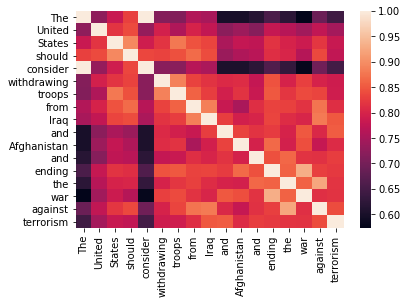

In [45]:
visualise_diffs(text, roberta_obama_model_embedding, roberta_obama_tokenizer)

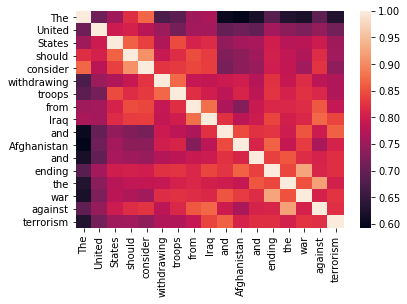

In [46]:
visualise_diffs(text, roberta_clinton_model_embedding, roberta_clinton_tokenizer)

Obama and Clinton turn out to be not that different in terms of their foreign policy stances on Iraq and Afghanistan although they started off with completely different positions. We know for a fact that Clinton shifted her position from supporting the war to ending it. Overall, the heatmaps show a similar pattern across the two then senators. 

### Post-training

After you finish training your models, you can download them by right clicking on each of the 8 files inside the name of your output folder. The largest file, pytorch_model.bin, is the file which does most of the heavy lifting but you need the other files to be able to use it later.